In [1]:
import os
import sys 
import pickle 
import joblib
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

if '../src' not in sys.path:
    sys.path.append('../src')

import config 

os.makedirs(config.MODEL_PATH, exist_ok = True)

In [2]:
print("Loading processed data...")
X_train = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'X_train.csv'))
y_train = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'y_train.csv')).squeeze()

X_val = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'X_val.csv'))
y_val = pd.read_csv(os.path.join(config.PROCESSED_DATA_PATH, 'y_val.csv')).squeeze()

print(f"Data loaded:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

Loading processed data...
Data loaded:
X_train shape: (32500, 31)
y_train shape: (32500,)
X_val shape: (7500, 31)
y_val shape: (7500,)


### Model Training & Hyperparameter Tuning Strategy

1.  **Logistic Regression:** A simple, interpretable linear model that serves as a strong baseline.
3.  **LightGBM:** A gradient boosting framework known for its high performance and efficiency.


In [3]:
models = {
    'LogisticRegression': LogisticRegression(random_state=config.RANDOM_STATE, max_iter=1000, solver='liblinear'),
    'XGBoost': XGBClassifier(random_state=config.RANDOM_STATE, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(random_state=config.RANDOM_STATE)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.RANDOM_STATE)

In [4]:
grid_search_results = []
best_estimators = {}

for model_name in config.MODELS_TO_TRAIN:
    print(f"\n>>> Tuning {model_name}...")
    model = models[model_name]
    param_grid = config.MODEL_PARAM_GRIDS[model_name]

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=skf,
        n_jobs=-1, 
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    result_info = {
        'Model': model_name,
        'Best F1 (Macro)': grid_search.best_score_,
        'Best Params': grid_search.best_params_
    }

    grid_search_results.append(result_info)
    best_estimators[model_name] = grid_search.best_estimator_

    print(f"Completed tuning for {model_name}. Best F1 Macro: {grid_search.best_score_:.4f}")
    print(f"Best Params: {grid_search.best_params_}")


>>> Tuning LogisticRegression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Completed tuning for LogisticRegression. Best F1 Macro: 0.9131
Best Params: {'C': 10.0, 'class_weight': 'balanced'}

>>> Tuning XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:24:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:24:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:24:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:24:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/hu

Completed tuning for XGBoost. Best F1 Macro: 0.9118
Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 3}

>>> Tuning LightGBM...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 6500, number of negative: 19500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3989
[LightGBM] [Info] Number of data points in the train set: 26000, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 6500, number of negative: 19500
[LightGBM] [Info] Number of positive: 6500, number of negative: 19500
[LightGBM] [Info] Number of positive: 6500, number of negative: 19500
[LightGBM] [Info] Number of positive: 6500, number of negative: 1

In [5]:
results_df = pd.DataFrame(grid_search_results).sort_values(by='Best F1 (Macro)', ascending=False)
print("\n--- Hyperparameter Tuning Results ---")
display(results_df)


--- Hyperparameter Tuning Results ---


,Model,Best F1 (Macro),Best Params
2,LightGBM,0.914331,"{'class_weight': 'balanced', 'learning_rate': ..."
0,LogisticRegression,0.913137,"{'C': 10.0, 'class_weight': 'balanced'}"
1,XGBoost,0.911757,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."


In [6]:
base_models = [
    (name, estimator) for name, estimator in best_estimators.items()
]
print("Base models for stacking:")
for name, _ in base_models:
    print(f"- {name}")

Base models for stacking:
- LogisticRegression
- XGBoost
- LightGBM


In [7]:
meta_model = LogisticRegression(random_state=config.RANDOM_STATE, max_iter=1000)
print(f"\nMeta-model: LogisticRegression")

for name, model in base_models:
    model.fit(X_train, y_train)


Meta-model: LogisticRegression


/home/huychan/anaconda3/envs/huyy/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:03:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 8125, number of negative: 24375
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3995
[LightGBM] [Info] Number of data points in the train set: 32500, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


In [8]:
meta_features = {}
for name, model in base_models:
    meta_features[name] = model.predict_proba(X_val)[:, 1]


meta_features_df = pd.DataFrame(meta_features)

print("Training meta-model...")
meta_model.fit(meta_features_df, y_val)
print("Meta-model trained.")

stacking_val_preds_proba = meta_model.predict_proba(meta_features_df)[:, 1]
stacking_val_f1_macro = f1_score(y_val, (stacking_val_preds_proba > 0.5).astype(int), average='macro') 

print(f"\nStacking Model Performance on Validation Set")
print(f"F1 Macro Score: {stacking_val_f1_macro:.4f}")
results_df.loc[len(results_df)] = ['Stacking', stacking_val_f1_macro, 'N/A']
results_df = results_df.sort_values(by='Best F1 (Macro)', ascending=False)

print("\n--- Final Model Comparison ---")
display(results_df)

Training meta-model...
Meta-model trained.

Stacking Model Performance on Validation Set
F1 Macro Score: 0.9180

--- Final Model Comparison ---


,Model,Best F1 (Macro),Best Params
3,Stacking,0.917995,N/A
2,LightGBM,0.914331,"{'class_weight': 'balanced', 'learning_rate': ..."
0,LogisticRegression,0.913137,"{'C': 10.0, 'class_weight': 'balanced'}"
1,XGBoost,0.911757,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti..."


In [9]:
champion_model_name = results_df.iloc[0]['Model']
print(f"\n==> The Champion Model is: {champion_model_name} <==")


==> The Champion Model is: Stacking <==


Optimal Threshold found: 0.62
Best F1 Macro Score on Validation Set at this threshold: 0.9199


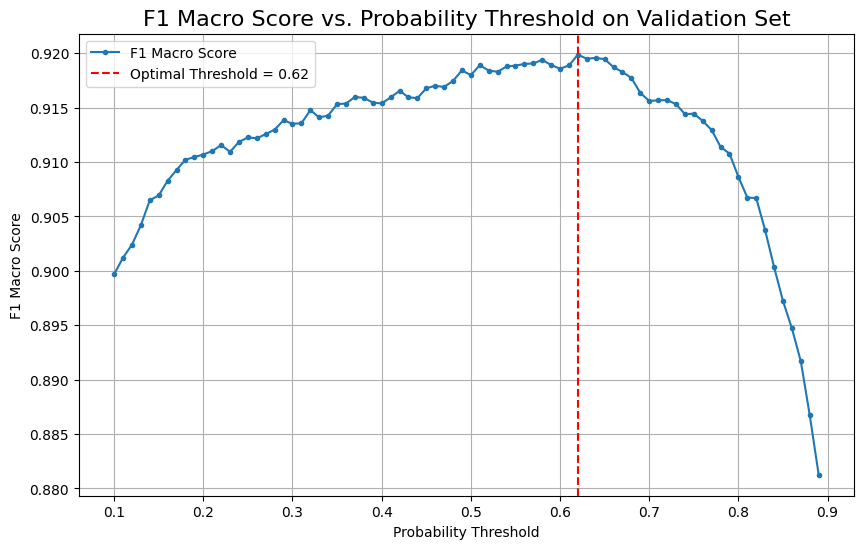

In [10]:
y_pred_proba_val = stacking_val_preds_proba

thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_class = (y_pred_proba_val >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_class, average='macro')
    f1_scores.append(f1)

best_f1_index = np.argmax(f1_scores)
optimal_threshold = thresholds[best_f1_index]
best_f1_score = f1_scores[best_f1_index]

print(f"Optimal Threshold found: {optimal_threshold:.2f}")
print(f"Best F1 Macro Score on Validation Set at this threshold: {best_f1_score:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, marker='.', label='F1 Macro Score')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.title('F1 Macro Score vs. Probability Threshold on Validation Set', fontsize=16)
plt.xlabel('Probability Threshold')
plt.ylabel('F1 Macro Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("\n--- Saving final artifacts from training ---")
final_champion_artifacts = {
    'base_models': {name: model for name, model in base_models},
    'meta_model': meta_model,
    'optimal_threshold': optimal_threshold,
    'model_name': champion_model_name
}

champion_model_path = os.path.join(config.MODEL_PATH, 'champion_model.joblib')
joblib.dump(final_champion_artifacts, champion_model_path)

print(f"Champion model artifacts saved to: {champion_model_path}")


--- Saving final artifacts from training ---
Champion model artifacts saved to: ../outputs/models/champion_model.joblib


: 